In [ ]:
# =============================
# Colab Notebook: bank_marketing_prediction.ipynb
# =============================

!pip install -q shap scikit-learn pandas matplotlib seaborn joblib

# Cell 1: Imports
import zipfile, requests, io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, auc
import joblib
import shap

In [ ]:
# Cell 2: Problem statement (Markdown cell recommended)
print("Objective: Predict whether a bank customer will subscribe to a term deposit after a marketing campaign.")

# Cell 3: Download & load dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip'
resp = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(resp.content))
z.extractall()
df = pd.read_csv("bank-additional/bank-additional-full.csv", sep=';')
print("Loaded dataset shape:", df.shape)
df.head()

Objective: Predict whether a bank customer will subscribe to a term deposit after a marketing campaign.
Loaded dataset shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
# Cell 4: Dataset description summary
print(df.info())
display(df.describe(include='all').T)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,41188.0,NaN,NaN,NaN,40.02406,10.42125,17.0,32.0,38.0,47.0,98.0
job,41188,12,admin.,10422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,41188,4,married,24928,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,41188,8,university.degree,12168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,41188,3,no,32588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
housing,41188,3,yes,21576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,41188,3,no,33950,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,41188,2,cellular,26144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,41188,10,may,13769,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,41188,5,thu,8623,NaN,NaN,NaN,NaN,NaN,NaN,NaN


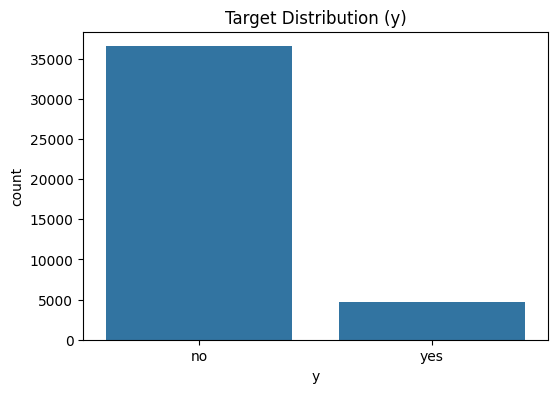

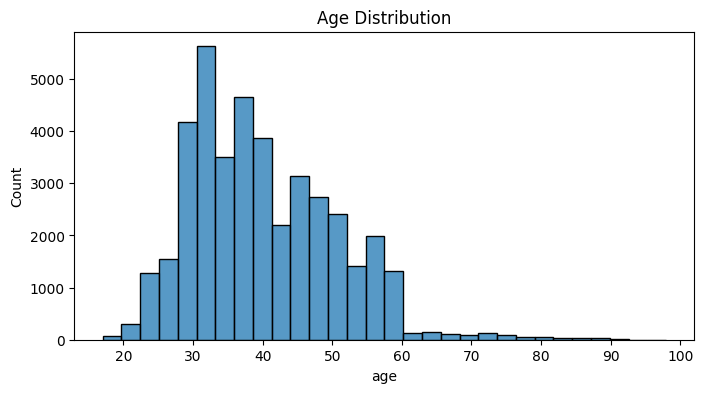

In [ ]:
# Cell 5: Quick EDA (add more as needed)
plt.figure(figsize=(6,4))
sns.countplot(x='y', data=df)
plt.title("Target Distribution (y)")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(df['age'], bins=30, kde=False)
plt.title('Age Distribution')
plt.show()

In [ ]:
# Cell 6: Preprocessing & encoding
# Create target binary
df['y_bin'] = df['y'].map({'yes':1, 'no':0})

# Separate features & target
X = df.drop(columns=['y', 'y_bin'])
y = df['y_bin']

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols.remove('duration')  # <-- Remove 'duration' here

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Build ColumnTransformer: scale numeric, OHE categorical
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])


Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
Numeric columns: ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [ ]:
# Cell 7: Model pipelines
log_pipe = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42))])
rf_pipe  = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))])

print("Training Logistic Regression...")
log_pipe.fit(X_train, y_train)
print("Training Random Forest...")
rf_pipe.fit(X_train, y_train)


Training Logistic Regression...
Training Random Forest...


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])


Logistic Regression -> F1: 0.4689, ROC-AUC: 0.8009
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      7310
           1       0.37      0.65      0.47       928

    accuracy                           0.84      8238
   macro avg       0.66      0.75      0.69      8238
weighted avg       0.88      0.84      0.85      8238



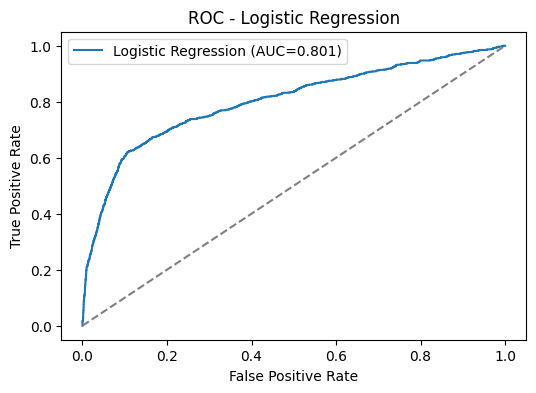

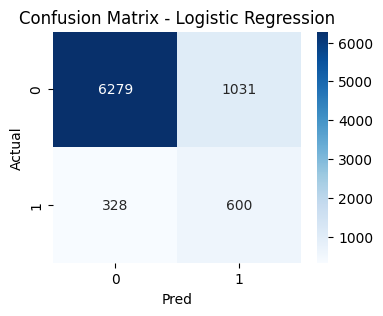


Random Forest -> F1: 0.3767, ROC-AUC: 0.7823
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7310
           1       0.57      0.28      0.38       928

    accuracy                           0.89      8238
   macro avg       0.74      0.63      0.66      8238
weighted avg       0.88      0.89      0.88      8238



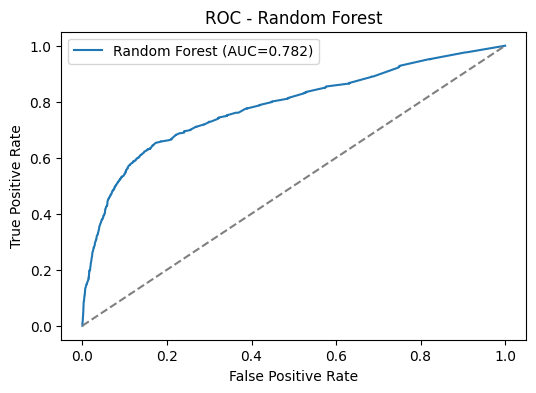

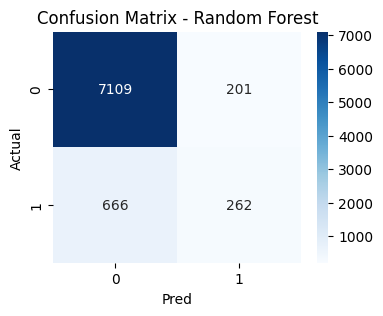

In [ ]:
# Cell 8: Evaluation helper + evaluate
def evaluate(pipe, X_test, y_test, name):
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)
    print(f"\n{name} -> F1: {f1:.4f}, ROC-AUC: {auc_score:.4f}")
    print(classification_report(y_test, y_pred))
    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title(f'ROC - {name}'); plt.legend(); plt.show()
    # Confusion matrix heatmap
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues'); plt.title(f'Confusion Matrix - {name}'); plt.xlabel('Pred'); plt.ylabel('Actual'); plt.show()
    return {'f1': f1, 'auc': auc_score, 'cm': cm}

res_log = evaluate(log_pipe, X_test, y_test, "Logistic Regression")
res_rf  = evaluate(rf_pipe, X_test, y_test, "Random Forest")

In [ ]:
# Cell 9: Feature names after preprocessing (needed for SHAP labeling)
preprocessor.fit(X_train)
num_features = num_cols
cat_ohe = preprocessor.named_transformers_['cat']
cat_feature_names = list(cat_ohe.get_feature_names_out(cat_cols))
feature_names = num_features + cat_feature_names
print("Total features after transform:", len(feature_names))

Total features after transform: 62


Saved SHAP background data to shap_bg.npy
Explaining test row indices (positions): [6373 3615 5391  734 3567]

Test position 6373 -> Pred=0, Prob=0.000


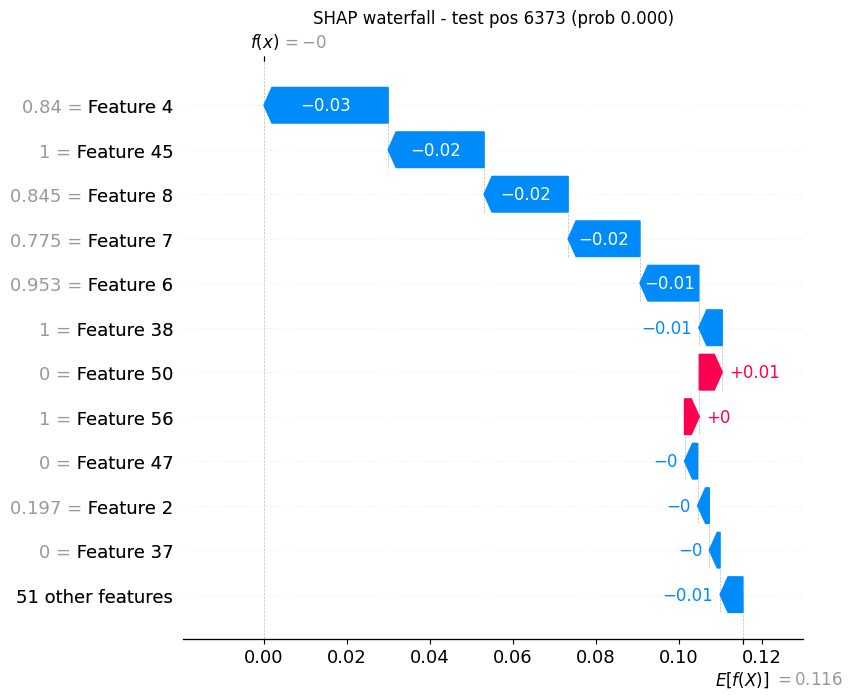

Top positive contributors:
 month_may            0.005538
day_of_week_thu      0.003557
default_unknown      0.002507
age                  0.002357
default_no           0.001822
contact_telephone    0.001742
campaign             0.001638
job_technician       0.001536
dtype: float64
Top negative contributors:
 pdays           -0.002824
month_jul       -0.003148
housing_yes     -0.005652
cons.conf.idx   -0.014194
euribor3m       -0.017322
nr.employed     -0.020267
month_aug       -0.023142
emp.var.rate    -0.029946
dtype: float64

Test position 3615 -> Pred=1, Prob=0.655


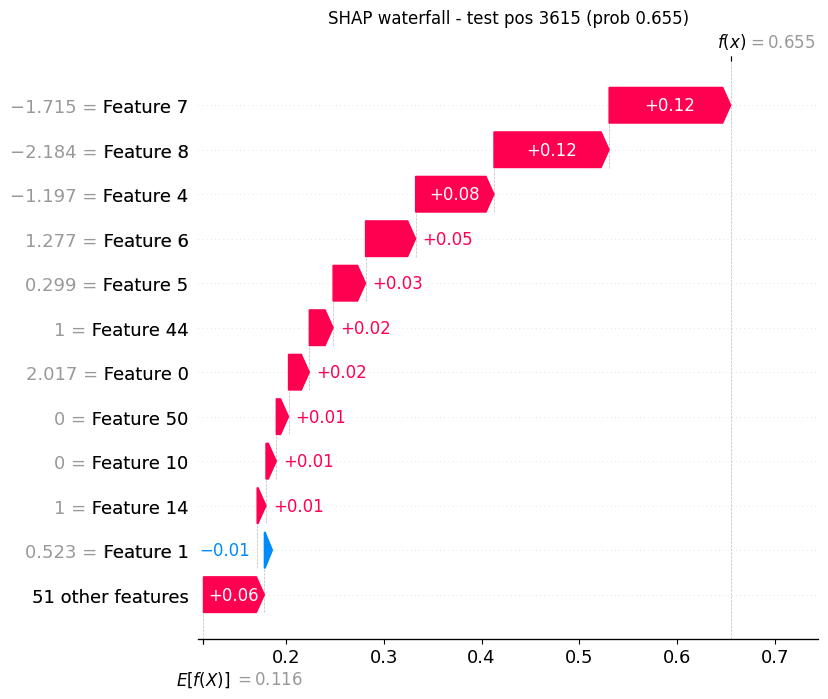

Top positive contributors:
 euribor3m         0.124435
nr.employed       0.117794
emp.var.rate      0.080181
cons.conf.idx     0.051238
cons.price.idx    0.033215
month_apr         0.024327
age               0.021268
month_may         0.012516
dtype: float64
Top negative contributors:
 loan_no                       -0.000862
housing_yes                   -0.000893
month_jul                     -0.000922
poutcome_success              -0.001995
education_university.degree   -0.002049
day_of_week_wed               -0.002782
pdays                         -0.003282
campaign                      -0.007399
dtype: float64

Test position 5391 -> Pred=0, Prob=0.015


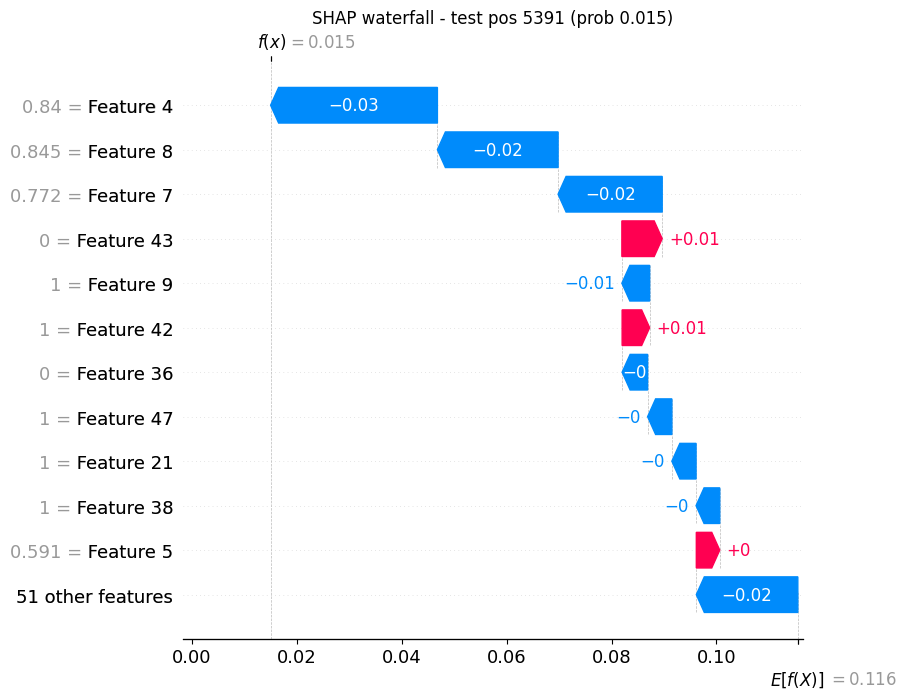

Top positive contributors:
 contact_telephone              0.007689
contact_cellular               0.005245
cons.price.idx                 0.004468
education_university.degree    0.001965
month_aug                      0.001800
default_no                     0.001708
job_technician                 0.001443
day_of_week_mon                0.001342
dtype: float64
Top negative contributors:
 housing_yes        -0.004516
marital_divorced   -0.004614
month_jul          -0.004626
housing_no         -0.004856
job_admin.         -0.005295
euribor3m          -0.019849
nr.employed        -0.023010
emp.var.rate       -0.031801
dtype: float64

Test position 734 -> Pred=1, Prob=0.765


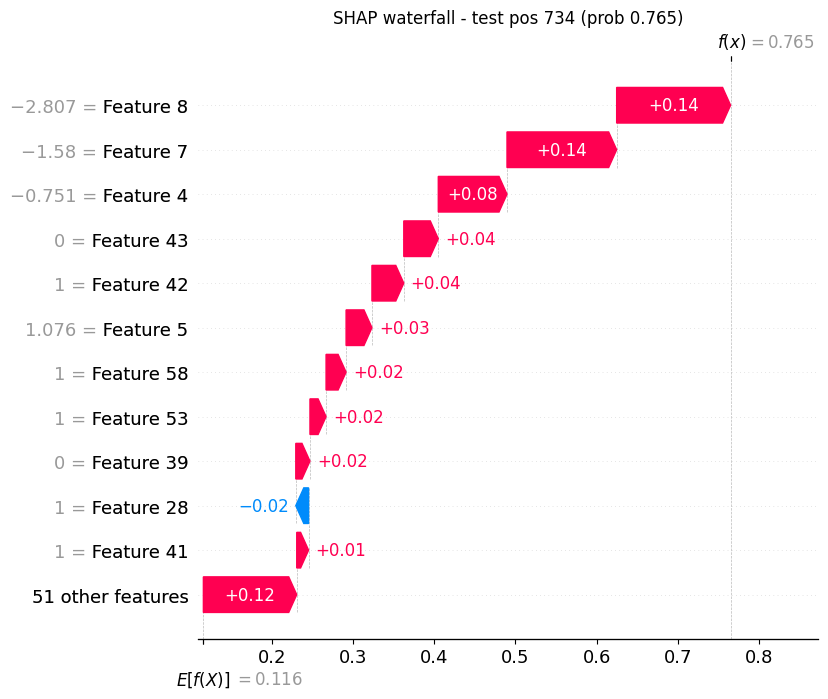

Top positive contributors:
 nr.employed          0.140340
euribor3m            0.135097
emp.var.rate         0.084644
contact_telephone    0.042504
contact_cellular     0.039225
cons.price.idx       0.031847
day_of_week_wed      0.024666
month_sep            0.019837
dtype: float64
Top negative contributors:
 month_jul               -0.000360
month_mar               -0.000467
job_retired             -0.000671
month_dec               -0.000726
day_of_week_tue         -0.000777
poutcome_success        -0.001831
pdays                   -0.003253
education_high.school   -0.015758
dtype: float64

Test position 3567 -> Pred=0, Prob=0.020


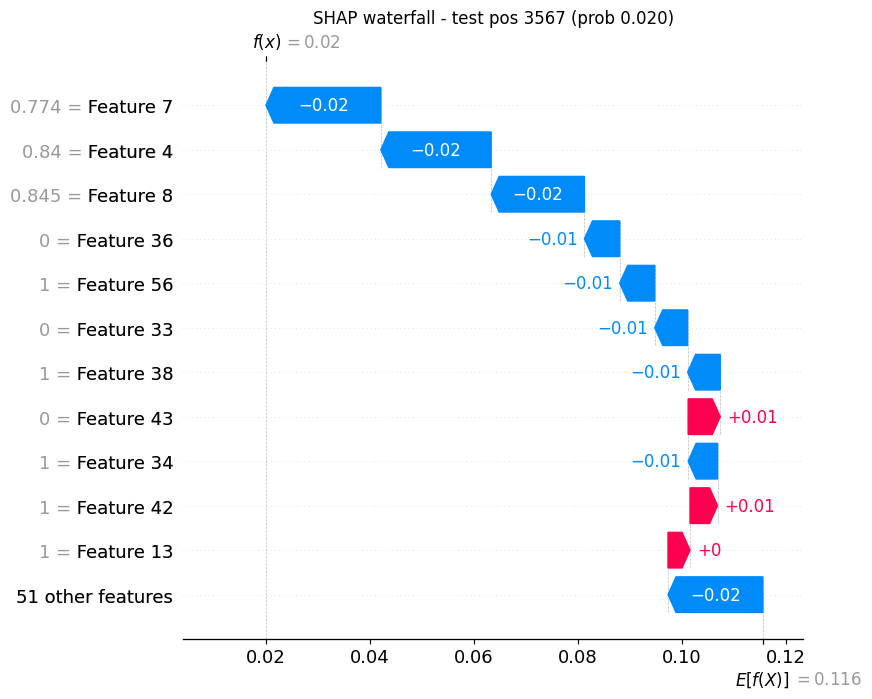

Top positive contributors:
 contact_telephone    0.006171
contact_cellular     0.005295
job_management       0.004231
month_may            0.003308
cons.price.idx       0.002849
month_aug            0.001977
campaign             0.001114
cons.conf.idx        0.000892
dtype: float64
Top negative contributors:
 default_unknown   -0.005656
housing_yes       -0.006275
default_no        -0.006315
day_of_week_thu   -0.006734
housing_no        -0.006773
nr.employed       -0.017929
emp.var.rate      -0.021213
euribor3m         -0.022077
dtype: float64


In [ ]:
# Cell 10: SHAP explanations for 5 test instances (SHAP v0.20+ compatible)
X_train_pre = preprocessor.transform(X_train)
X_test_pre  = preprocessor.transform(X_test)

rf_clf = rf_pipe.named_steps['clf']

bg = shap.sample(X_train_pre, 100, random_state=42)
np.save('shap_bg.npy', bg)# Save background to .npy file for later use in your Streamlit app
explainer = shap.Explainer(rf_clf, bg)
print("Saved SHAP background data to shap_bg.npy")

rng = np.random.default_rng(42)
sample_indices = rng.choice(X_test_pre.shape[0], size=5, replace=False)
print("Explaining test row indices (positions):", sample_indices)

for pos in sample_indices:
    X_inst_pre = X_test_pre[pos].reshape(1, -1)
    X_inst_orig = X_test.iloc[pos:pos+1]

    prob = rf_pipe.predict_proba(X_inst_orig)[0, 1]
    pred = rf_pipe.predict(X_inst_orig)[0]
    print(f"\nTest position {pos} -> Pred={pred}, Prob={prob:.3f}")

    shap_exp = explainer(X_inst_pre)

    if shap_exp.values.ndim == 3:
        shap_exp = shap.Explanation(
            values=shap_exp.values[:, :, 1],
            base_values=shap_exp.base_values[:, 1],
            data=shap_exp.data,
            feature_names=shap_exp.feature_names
        )

    plt.title(f"SHAP waterfall - test pos {pos} (prob {prob:.3f})")
    shap.plots.waterfall(shap_exp[0], max_display=12)
    plt.show()

    vals = shap_exp.values[0]
    s = pd.Series(vals, index=feature_names).sort_values(ascending=False)
    print("Top positive contributors:\n", s.head(8))
    print("Top negative contributors:\n", s.tail(8))



In [ ]:
# Cell 11: Save the best pipeline for deployment
joblib.dump(rf_pipe, "rf_pipeline.joblib")
print("Saved pipeline: rf_pipeline.joblib")

Saved pipeline: rf_pipeline.joblib


In [ ]:
import joblib
import cloudpickle
import gzip

# Load your existing joblib file
model = joblib.load("rf_pipeline.joblib")

# Save with cloudpickle + gzip compression
with gzip.open("rf_pipeline_cloud.pkl.gz", "wb") as f:
    cloudpickle.dump(model, f)

print(" Compressed model saved: rf_pipeline_cloud.pkl.gz")

# Download
from google.colab import files
files.download("rf_pipeline_cloud.pkl.gz")


 Compressed model saved: rf_pipeline_cloud.pkl.gz


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>